# Person Detection Using MobileNetV2 Trained on COCO 2017 Dataset

In this notebook, we will fine-tune the MobileNetV2 model using the COCO 2017 dataset to detect a person. The dataset will be converted to grayscale to match the input format of our camera (Himax We-I).

## Step 1: Install Dependencies

We first need to install the necessary libraries: TensorFlow, pycocotools (to work with the COCO dataset), and OpenCV (to handle image processing).



In [ ]:
!pip install tensorflow pycocotools opencv-python numpy  requests  matplotlib ipywidgets

In [57]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Input, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_model_optimization as tfmot
import cv2
import numpy as np
import os
import shutil
import zipfile
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import requests

In [58]:
# Define download paths
data_dir = './coco2017/'
images_zip_path = os.path.join(data_dir, 'train2017.zip')
annotations_zip_path = os.path.join(data_dir, 'annotations_trainval2017.zip')

In [2]:
# Define the COCO dataset URLs
coco_images_url = 'http://images.cocodataset.org/zips/train2017.zip'
coco_annotations_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'

# Define download paths
data_dir = './coco2017/'
images_zip_path = os.path.join(data_dir, 'train2017.zip')
annotations_zip_path = os.path.join(data_dir, 'annotations_trainval2017.zip')

# Create directory to store dataset
os.makedirs(data_dir, exist_ok=True)

# Download images
if not os.path.exists(os.path.join(data_dir, 'train2017')):
    print("Downloading COCO train images...")
    r = requests.get(coco_images_url, stream=True)
    with open(images_zip_path, 'wb') as f:
        shutil.copyfileobj(r.raw, f)
    
    # Unzip images
    with zipfile.ZipFile(images_zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    print("COCO train images downloaded and extracted.")

# Download annotations
if not os.path.exists(os.path.join(data_dir, 'annotations')):
    print("Downloading COCO annotations...")
    r = requests.get(coco_annotations_url, stream=True)
    with open(annotations_zip_path, 'wb') as f:
        shutil.copyfileobj(r.raw, f)
    
    # Unzip annotations
    with zipfile.ZipFile(annotations_zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    print("COCO annotations downloaded and extracted.")

In [59]:
# Initialize COCO API
annotation_file = os.path.join(data_dir, 'annotations/instances_train2017.json') 
coco = COCO(annotation_file)

# Get the category ID for "person"
person_category_id = coco.getCatIds(catNms=['person'])[0]

# Get all images containing people (positive samples)
person_image_ids = coco.getImgIds(catIds=[person_category_id])

# Get some images without people (negative samples)
all_image_ids = coco.getImgIds()
non_person_image_ids = list(set(all_image_ids) - set(person_image_ids))

# Load and preprocess the image, convert grayscale to 3-channel by replicating
def load_and_preprocess_image(coco, img_id, data_dir, img_size=(224, 224)):
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(data_dir, 'train2017', img_info['file_name'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    
    img = cv2.resize(img, img_size)  # Resize to match MobileNetV2 input size
    img = np.expand_dims(img, axis=-1)  # Add channel dimension for grayscale image
    return img


# Load person images
person_images = [load_and_preprocess_image(coco, img_id, data_dir) for img_id in person_image_ids[:2000]]  
non_person_images = [load_and_preprocess_image(coco, img_id, data_dir) for img_id in non_person_image_ids[:2000]]

# Create labels (1 for person, 0 for non-person)
labels = np.array([1] * len(person_images) + [0] * len(non_person_images))

# Combine images and shuffle the dataset
images = np.array(person_images + non_person_images)
indices = np.random.permutation(len(images))
images, labels = images[indices], labels[indices]

loading annotations into memory...
Done (t=9.57s)
creating index...
index created!


Original

In [24]:


# Define a new input layer that accepts grayscale (1-channel) images
input_layer = Input(shape=(224, 224, 1))

# Use Conv2D to change 1-channel input to 3-channel so it can work with MobileNetV2
x = Conv2D(3, (3, 3), padding='same', activation='relu')(input_layer)

# Load pre-trained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Modify the first layer to accept 1-channel input and broadcast to 3 channels
input_layer = Input(shape=(224, 224, 1))  # Grayscale input
x = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(input_layer)  # Convert grayscale to RGB

# Connect the base model
base_model_output = base_model(x)

# Add custom layers on top of the base model
x = Dropout(0.5)(x)  # Added Dropout for regularization
x = Dense(64, activation='relu')(x)  # Added Dense layer for more complexity

x = GlobalAveragePooling2D()(base_model_output)
x = Dense(1, activation='sigmoid')(x)  # For binary classification (person vs non-person)

# Create the final model
model = Model(inputs=input_layer, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

test_1

In [66]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Conv2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

# Define the input layer accepting grayscale (1-channel) images
input_layer = Input(shape=(224, 224, 1), name="input_layer_grayscale")

# Convert grayscale to RGB using Lambda function
x = Lambda(lambda x: tf.image.grayscale_to_rgb(x), name="grayscale_to_rgb")(input_layer)

# Use Conv2D to handle the 1-channel to 3-channel conversion before passing to MobileNetV2
x = Conv2D(3, (3, 3), padding='same', activation='relu', name="conv2d_1")(x)

# Load pre-trained MobileNetV2 model without the top layers (set include_top=False)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3), name="mobilenet_base")

# Apply MobileNetV2 on the input
x = base_model(x)

# Add Global Average Pooling after the base model
x = GlobalAveragePooling2D(name="global_avg_pool")(x)

# Add custom layers for classification
x = Dropout(0.5, name="dropout")(x)  # Regularization with Dropout
x = Dense(64, activation='relu', name="dense_64")(x)  # Added Dense layer

# Final output layer for binary classification (person vs non-person)
output = Dense(1, activation='sigmoid', name="output_layer")(x)

# Create the final model
model = Model(inputs=input_layer, outputs=output, name="person_detection_model")

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [67]:
print(type(model))


<class 'keras.src.models.functional.Functional'>


In [61]:
# Define the pruning parameters (you can adjust these values if needed)
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0,
        final_sparsity=0.5,
        begin_step=0,
        end_step=1000
    )
}

In [65]:
# Define the pruning parameters
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0,
        final_sparsity=0.5,
        begin_step=0,
        end_step=1000
    )
}

# Wrap the model for pruning using prune_low_magnitude
# Apply it after creating the model, and before compiling or training it
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

# Compile the pruned model
pruned_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

ValueError: `prune_low_magnitude` can only prune an object of the following types: keras.models.Sequential, keras functional model, keras.layers.Layer, list of keras.layers.Layer. You passed an object of type: Functional.

In [63]:
def preprocess_input(images):
    # If images are in (batch_size, height, width) format, add channel dimension
    if images.ndim == 3:
        images = np.expand_dims(images, axis=-1)  # Add grayscale channel
    elif images.ndim == 4 and images.shape[-1] != 1:  # Handle other cases
        raise ValueError("Images must be in grayscale format with shape (batch_size, 224, 224, 1).")
    return images  # Return images with shape (batch_size, height, width, channels)

# ImageDataGenerator for augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


# Assuming 'images' is a 4D array with shape (batch_size, 224, 224, 1)
train_generator = datagen.flow(
    images,  # Raw images, no need to preprocess explicitly here
    labels,
    batch_size=32,
    subset='training'
)

val_generator = datagen.flow(
    images,
    labels,
    batch_size=32,
    subset='validation'
)

# Learning rate scheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=1
)

# Fine-tuning MobileNetV2
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False


In [ ]:
# Train the model
history = pruned_model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=15
)

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Epoch 1/15


c:\Users\xxnab\OneDrive\Documents\GitHub\FYP\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 698ms/step - accuracy: 0.5241 - loss: 0.7224 - val_accuracy: 0.5038 - val_loss: 0.6956
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 711ms/step - accuracy: 0.5054 - loss: 0.6954 - val_accuracy: 0.4963 - val_loss: 0.7105
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 74s 739ms/step - accuracy: 0.5229 - loss: 0.6921 - val_accuracy: 0.4963 - val_loss: 0.7145
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 73s 727ms/step - accuracy: 0.5610 - loss: 0.6854 - val_accuracy: 0.4963 - val_loss: 0.7245
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 716ms/step - accuracy: 0.5740 - loss: 0.6775 - val_accuracy: 0.5150 - val_loss: 0.6975
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 718ms/step - accuracy: 0.5766 - loss: 0.6697 - val_accuracy: 0.6000 - val_loss: 0.7144
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 73s 723ms/step - accuracy: 0.5888 - loss: 0.6730 - val_accuracy: 0.5562 - val_loss: 1.1941
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 73s 726ms/step - accuracy: 0.7113 - loss: 0.5701 - val

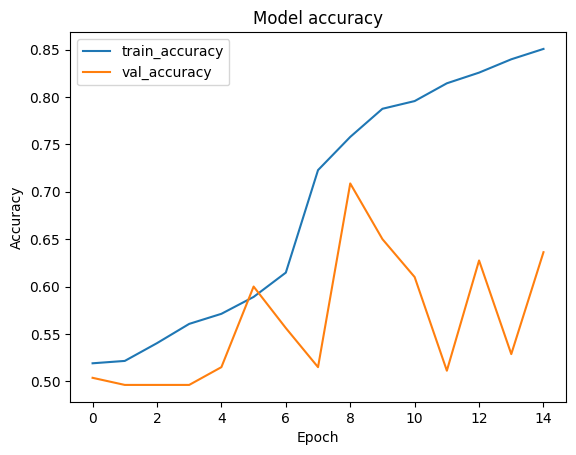

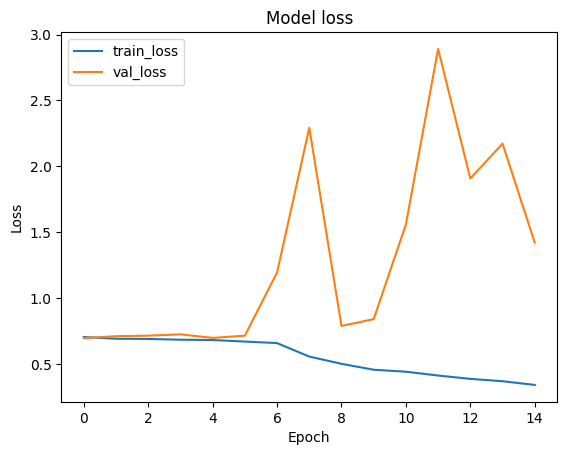

In [48]:
# Train the model
history = model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=15
)


# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [35]:
model.save('model/model_v2.keras')

Pruning

In [50]:
# Apply pruning to the entire model
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

# Compile the pruned model (important to recompile)
pruned_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Print pruned model summary to ensure correctness
pruned_model.summary()

ValueError: `prune_low_magnitude` can only prune an object of the following types: keras.models.Sequential, keras functional model, keras.layers.Layer, list of keras.layers.Layer. You passed an object of type: Functional.

In [ ]:
# Continue training on the pruned model if necessary
pruned_model.fit(train_data, train_labels, epochs=5, validation_data=(val_data, val_labels))

Quantize

In [ ]:
import tensorflow as tf

# Convert the pruned model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)

# Enable quantization (optional, but recommended for smaller size)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Optional: If you have a representative dataset, use it for better quantization
# def representative_dataset_gen():
#     for input_value in dataset.take(100):  # Example dataset for quantization
#         yield [input_value]

# converter.representative_dataset = representative_dataset_gen

# Convert the model to TFLite
tflite_model = converter.convert()


In [ ]:
# Save the TensorFlow Lite model to a file
with open('pruned_quantized_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Optionally, check the model size
import os
file_size = os.path.getsize('pruned_quantized_model.tflite') / (1024 * 1024)
print(f"Pruned and Quantized Model Size: {file_size:.2f} MB")


In [ ]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="pruned_quantized_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Example: Evaluate on a single sample
interpreter.set_tensor(input_details[0]['index'], sample_input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)
